## Final Project

In this final project, I chose to replicate the following published article: "Optimal forecast reconciliation for hierarchical and clustered time series through trace minimization" by Shanika L. Wickramasuriya, George Athanasopoulos and Rob J. Hyndman. These authors evaluate the performance of the proposed new forecast reconciliation method (MinT) against alternative methods through a simulation as well as an empirical application using Australian domestic tourism data.
Thus, I will replicate the empirical application, using data from Portuguese domestic tourism. For this I will use the scikits-hit package, which is used for general hierarchical time series modeling. Since this package does not support the proposed new forecast reconciliation method, I will compare all forecast reconciliation methods supported by this package in order to choose the most accurate one. Besides, in the article, the authors used ARIMA and ETS models, but in this project I will use ARIMA and Prophet models, since the ETS it is not supported by the scikits-hts package. 


In [1]:
import pandas as pd
import numpy as np

import hts
from hts import HTSRegressor
import pmdarima as pm
from fbprophet import Prophet


import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from hts.hierarchy import HierarchyTree



## 1. Treatment of the data

In [2]:
# figure settings
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (7, 5)

In [3]:
# import the data files
data = pd.read_excel('./data - Continente e Ilhas.xlsx',sheet_name='Sheet2', skiprows=2, usecols="A:D", header=None, index_col=0)

In [4]:
first_row = data.loc["Years",:]
data.columns=first_row
data.drop(data.index[[0]],inplace=True)

In [5]:
# lowercase the column names
data.columns = [col_name.lower() for col_name in data.columns]

In [6]:
# map the full NUTSI names to abbreviations
nutsi_dict = {
    "Portugal Continental": "PT_C",
    "Regiões Autónomas": "RA",
}

data["nutsi"] = data["nutsi"].map(nutsi_dict)

# map the full Zones names to abbreviations
zones_dict = {
    "Norte e Centro": "NT&CT",
    "Sul": "S",
    "Região Autónoma dos Açores": "AÇR",
    "Região Autónoma da Madeira": "MAD",
}

data["zones"] = data["zones"].map(zones_dict)

# create the bottom level id
data["nutsi_zones"] = data.apply(lambda x: f"{x['nutsi']}_{x['zones']}", axis=1)

data.head()

,nutsi,zones,nº of nights,nutsi_zones
0,,,,
2012-12-31 00:00:00,PT_C,NT&CT,2333.144,PT_C_NT&CT
2012-12-31 00:00:00,PT_C,S,15468.919,PT_C_S
2012-12-31 00:00:00,RA,MAD,5507.685,RA_MAD
2012-12-31 00:00:00,RA,AÇR,257.839,RA_AÇR
2013-12-31 00:00:00,PT_C,NT&CT,11486.045,PT_C_NT&CT


In [7]:
data.reset_index(inplace=True)
data.columns.values[0]="date"
data.head()

,date,nutsi,zones,nº of nights,nutsi_zones
0,2012-12-31,PT_C,NT&CT,2333.144,PT_C_NT&CT
1,2012-12-31,PT_C,S,15468.919,PT_C_S
2,2012-12-31,RA,MAD,5507.685,RA_MAD
3,2012-12-31,RA,AÇR,257.839,RA_AÇR
4,2013-12-31,PT_C,NT&CT,11486.045,PT_C_NT&CT


In [8]:
# analyze all the zones per nutsi
data.groupby("nutsi")["zones"].apply(set).to_frame()

,zones
nutsi,
PT_C,"{S, NT&CT}"
RA,"{AÇR, MAD}"


In [9]:
# create the bottom level data
data_bottom_level = data.pivot(index="date", columns="nutsi_zones", values="nº of nights")

# create the middle level data
data_middle_level = data.groupby(["date", "nutsi"]).sum().reset_index(drop=False).pivot(index="date", columns="nutsi", values="nº of nights")

# create the total level data
data_total = data.groupby("date")["nº of nights"].sum().to_frame().rename(columns={"nº of nights": "total"})


In [10]:

# join the DataFrames
hierarchy_data = data_bottom_level.join(data_middle_level).join(data_total)
hierarchy_data.index = pd.to_datetime(hierarchy_data.index)


print(f"Number of time series at the bottom level: {data_bottom_level.shape[1]}")
print(f"Number of time series at the middle level: {data_middle_level.shape[1]}")

hierarchy_data

Number of time series at the bottom level: 4
Number of time series at the middle level: 2


,PT_C_NT&CT,PT_C_S,RA_AÇR,RA_MAD,PT_C,RA,total
date,,,,,,,
2012-12-31,2333.144,15468.919,257.839,5507.685,17802.063,5765.524,23567.587
2013-12-31,11486.045,15309.166,269.142,288.579,26795.211,557.721,27352.932
2014-12-31,22828.113,18255.844,1081.949,6506.866,41083.957,7588.815,48672.772
2015-12-31,25529.004,19180.704,1289.414,7030.026,44709.708,8319.440,53029.148
2016-12-31,28434.06,21140.151,1569.176,7930.908,49574.211,9500.084,59074.295
2017-12-31,32468.334,22694.536,1808.448,8359.989,55162.870,10168.437,65331.307
2018-12-31,34072.819,23119.192,2085.219,8344.266,57192.011,10429.485,67621.496
2019-12-31,36584.637,23839.325,2231.414,7457.197,60423.962,9688.611,70112.573
2020-12-31,12982.421,9719.966,654.376,2441.536,22702.387,3095.912,25798.299


In [11]:
#Creating the hierarchy
nutsi = data["nutsi"].unique()
zones = data["nutsi_zones"].unique()

total = {'total': list(nutsi)}
nutsi = {k: [v for v in zones if v.startswith(k)] for k in nutsi}
hierarchy = {**total, **nutsi}

hierarchy

{'total': ['PT_C', 'RA'],
 'PT_C': ['PT_C_NT&CT', 'PT_C_S'],
 'RA': ['RA_MAD', 'RA_AÇR']}

In [12]:
Htree = HierarchyTree.from_nodes(nodes=hierarchy, df=hierarchy_data)
Htree

- total
   |- PT_C
   |  |- PT_C_NT&CT
   |  - PT_C_S
   - RA
      |- RA_MAD
      - RA_AÇR

## 2. Data visualization

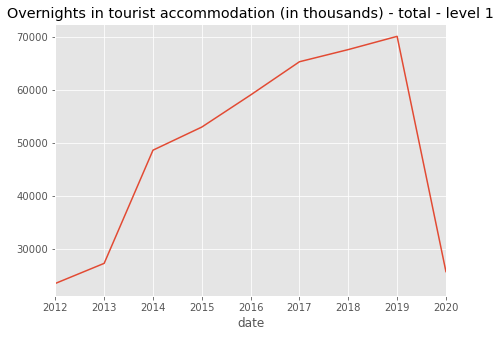

In [13]:
hierarchy_data["total"].plot(title="Overnights in tourist accommodation (in thousands) - total - level 1");

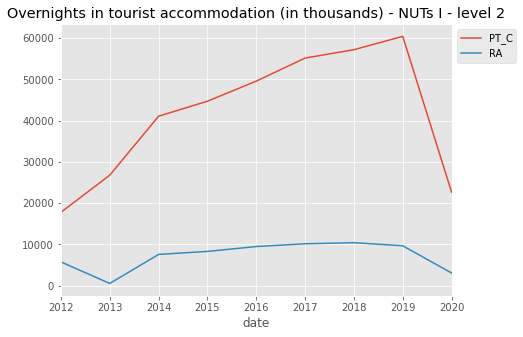

In [14]:
ax = hierarchy_data[hierarchy['total']].plot(title="Overnights in tourist accommodation (in thousands) - NUTs I - level 2")
ax.legend(bbox_to_anchor=(1.0, 1.0));

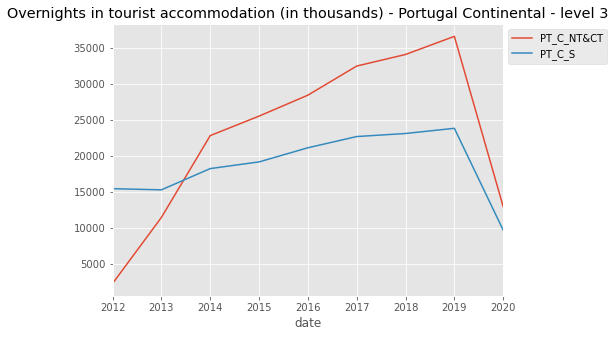

In [15]:
ax = hierarchy_data[hierarchy['PT_C']].plot(title="Overnights in tourist accommodation (in thousands) - Portugal Continental - level 3")
ax.legend(bbox_to_anchor=(1.0, 1.0));

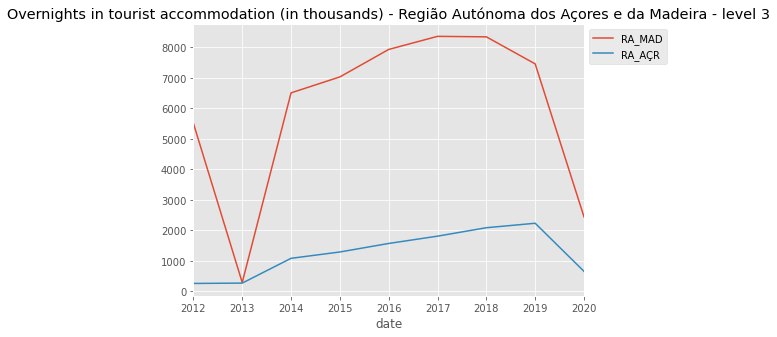

In [16]:
ax = hierarchy_data[hierarchy['RA']].plot(title="Overnights in tourist accommodation (in thousands) - Região Autónoma dos Açores e da Madeira - level 3")
ax.legend(bbox_to_anchor=(1.0, 1.0));

## 3. Hierarchical time series Forecasting

In [17]:
def plot_results(cols, axes, preds):
    axes = np.hstack(axes)
    for ax, col in zip(axes, cols):
        preds[col].plot(ax=ax, label="Predicted")
        hierarchy_data[col].plot(ax=ax, label="Observed")

        ax.legend()
        ax.set_title(col)
        ax.set_xlabel("Date")
        ax.set_ylabel("N of Nights")

## 3.1. Using Arima as base forecast

Calculating forecasts using Arima model as base forecast.

## A) Bottom-up approach

Using the Bottom-up approach as a revision method (BU).

In [18]:
arima_bu = hts.HTSRegressor(model='auto_arima', revision_method='BU', n_jobs=0)
arima_bu = arima_bu.fit(hierarchy_data, hierarchy)
pred_arima_bu = arima_bu.predict(steps_ahead=1)

Fitting models: 100%|███████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 291.69it/s]


In [19]:
pred_arima_bu.round()

,total,PT_C,RA,PT_C_NT&CT,PT_C_S,RA_MAD,RA_AÇR
2012-12-31,47701.0,5985.0,41716.0,22969.0,18748.0,5985.0,0.0
2013-12-31,47921.0,6205.0,41716.0,22969.0,18748.0,5985.0,220.0
2014-12-31,47931.0,6215.0,41716.0,22969.0,18748.0,5985.0,230.0
2015-12-31,48624.0,6908.0,41716.0,22969.0,18748.0,5985.0,923.0
2016-12-31,48801.0,7085.0,41716.0,22969.0,18748.0,5985.0,1100.0
2017-12-31,49040.0,7324.0,41716.0,22969.0,18748.0,5985.0,1338.0
2018-12-31,49244.0,7528.0,41716.0,22969.0,18748.0,5985.0,1543.0
2019-12-31,49480.0,7764.0,41716.0,22969.0,18748.0,5985.0,1779.0
2020-12-31,49605.0,7889.0,41716.0,22969.0,18748.0,5985.0,1903.0
2021-01-01,48260.0,6543.0,41716.0,22969.0,18748.0,5985.0,558.0


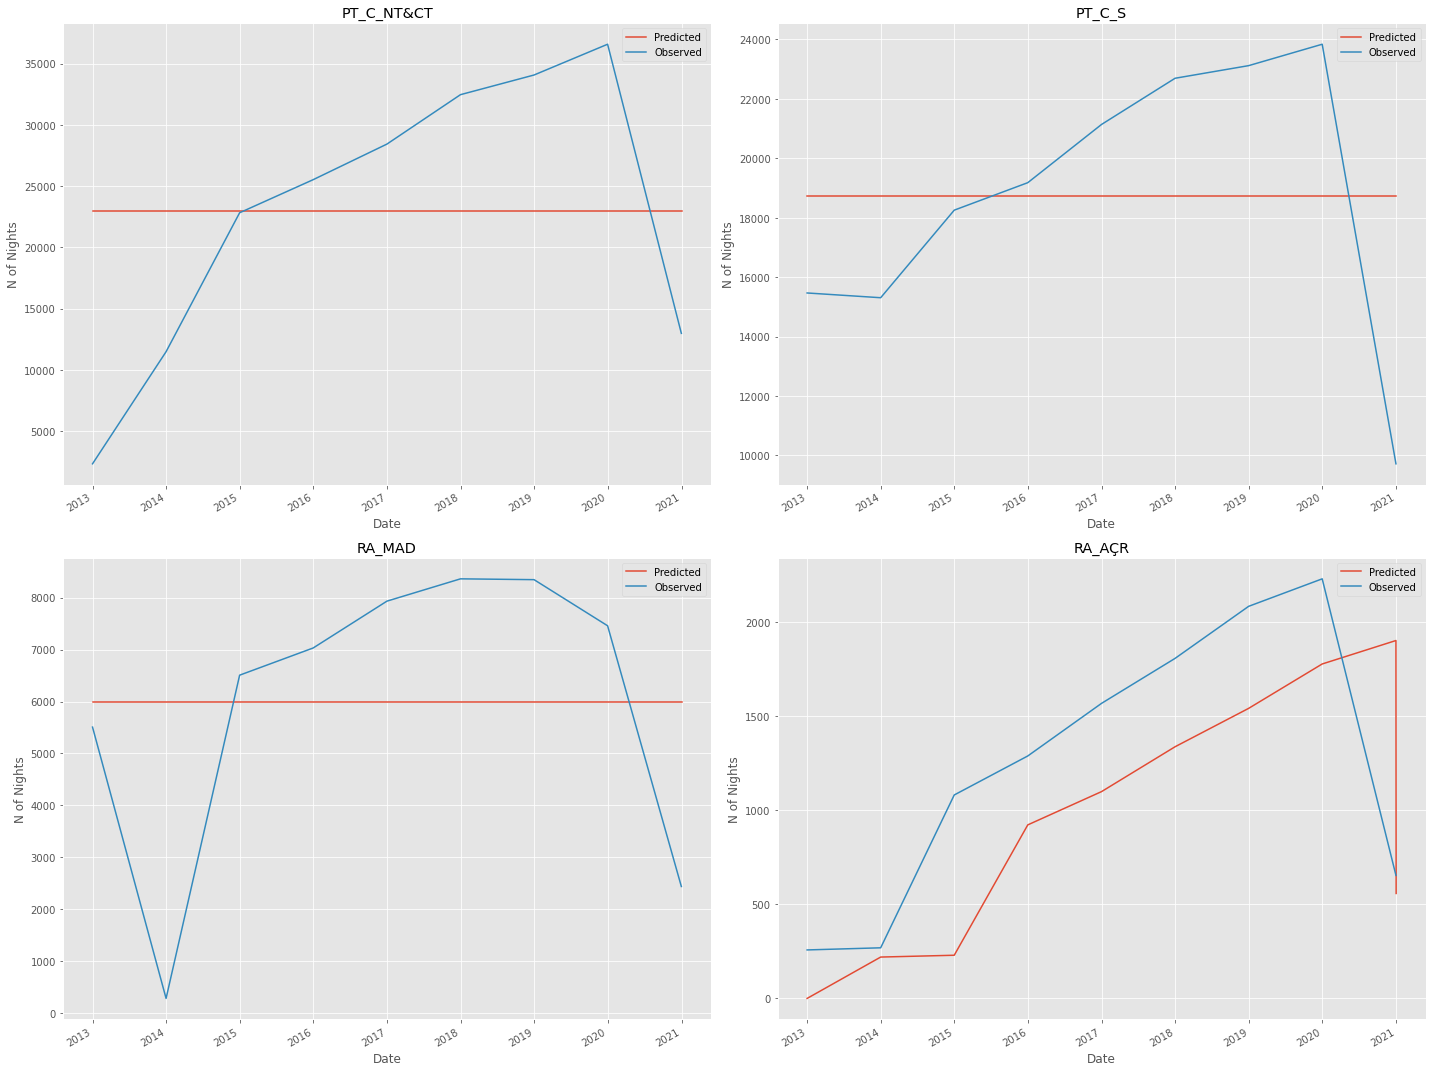

In [20]:
fig, axes = plt.subplots(2, 2, figsize=(20, 15))
plot_results(zones, axes, pred_arima_bu)
plt.tight_layout()

## B) Top-down approach

Using the Top-down approach as a revision method (AHP).

In [21]:
arima_td = hts.HTSRegressor(model='auto_arima', revision_method='AHP', n_jobs=0)
arima_td = arima_td.fit(hierarchy_data, hierarchy)
pred_arima_td = arima_td.predict(steps_ahead=1)

Fitting models: 100%|███████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 349.86it/s]


In [22]:
pred_arima_td.round()

,total,PT_C,RA,PT_C_NT&CT,PT_C_S,RA_MAD,RA_AÇR
2012-12-31,48951.0,7107.0,41844.0,21629.0,20215.0,5967.0,1140.0
2013-12-31,48951.0,7107.0,41844.0,21629.0,20215.0,5967.0,1140.0
2014-12-31,48951.0,7107.0,41844.0,21629.0,20215.0,5967.0,1140.0
2015-12-31,48951.0,7107.0,41844.0,21629.0,20215.0,5967.0,1140.0
2016-12-31,48951.0,7107.0,41844.0,21629.0,20215.0,5967.0,1140.0
2017-12-31,48951.0,7107.0,41844.0,21629.0,20215.0,5967.0,1140.0
2018-12-31,48951.0,7107.0,41844.0,21629.0,20215.0,5967.0,1140.0
2019-12-31,48951.0,7107.0,41844.0,21629.0,20215.0,5967.0,1140.0
2020-12-31,48951.0,7107.0,41844.0,21629.0,20215.0,5967.0,1140.0
2021-01-01,48951.0,7107.0,41844.0,21629.0,20215.0,5967.0,1140.0


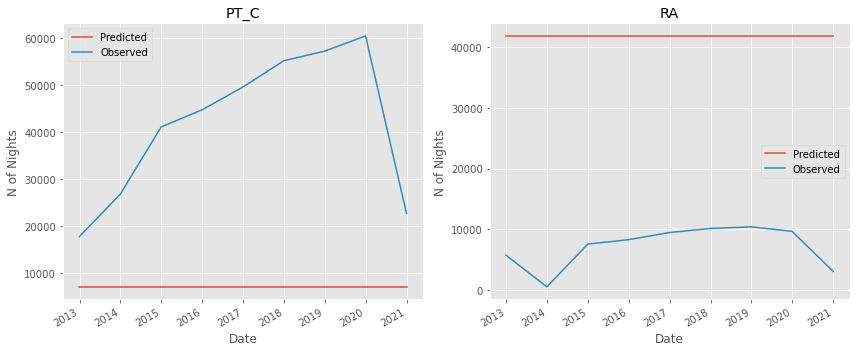

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plot_results(nutsi, axes, pred_arima_td)
plt.tight_layout()

## C) optimal combination using OLS approach

Using the OLS approach as a revision method (OLS).

In [24]:
arima_ols = hts.HTSRegressor(model='auto_arima', revision_method='OLS', n_jobs=0)
arima_ols = arima_ols.fit(hierarchy_data, hierarchy)
pred_arima_ols = arima_ols.predict(steps_ahead=1)

Fitting models: 100%|███████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 291.46it/s]


In [25]:
pred_arima_ols.round()

,total,PT_C,RA,PT_C_NT&CT,PT_C_S,RA_MAD,RA_AÇR
2012-12-31,48773.0,29925.0,18848.0,11534.0,7313.0,17955.0,11970.0
2013-12-31,48804.0,29977.0,18827.0,11524.0,7303.0,17871.0,12106.0
2014-12-31,48805.0,29980.0,18826.0,11524.0,7302.0,17868.0,12112.0
2015-12-31,48904.0,30145.0,18760.0,11491.0,7269.0,17604.0,12541.0
2016-12-31,48930.0,30187.0,18743.0,11482.0,7261.0,17536.0,12651.0
2017-12-31,48964.0,30244.0,18720.0,11471.0,7250.0,17445.0,12798.0
2018-12-31,48993.0,30292.0,18701.0,11461.0,7240.0,17367.0,12925.0
2019-12-31,49027.0,30348.0,18678.0,11450.0,7229.0,17278.0,13071.0
2020-12-31,49045.0,30378.0,18666.0,11444.0,7223.0,17230.0,13148.0
2021-01-01,48852.0,30058.0,18795.0,11508.0,7287.0,17742.0,12315.0


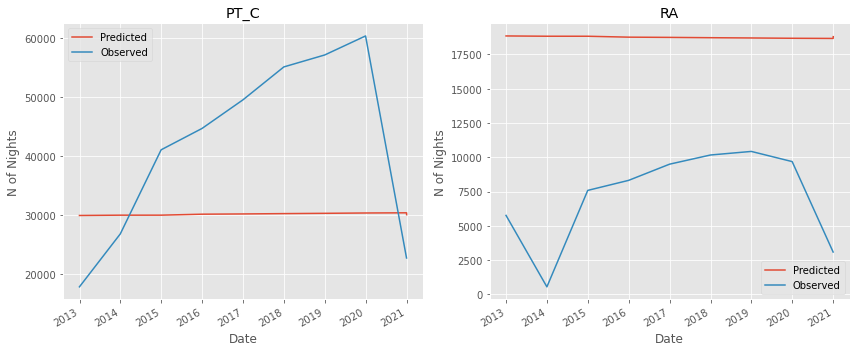

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plot_results(nutsi, axes, pred_arima_ols)
plt.tight_layout()

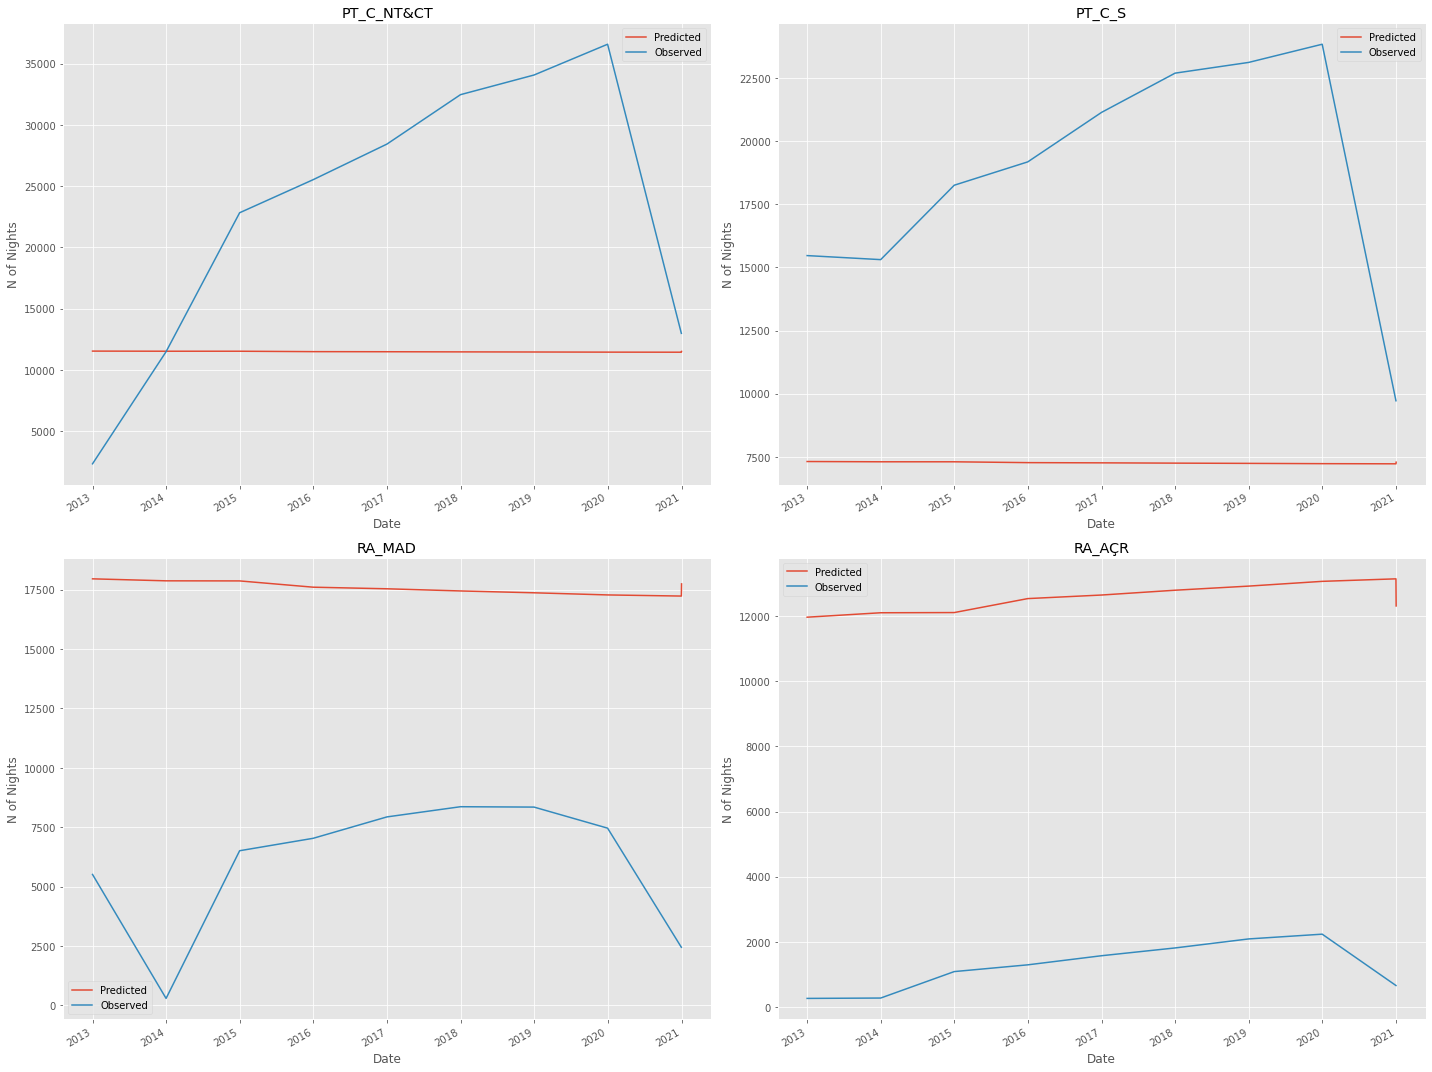

In [27]:
fig, axes = plt.subplots(2, 2, figsize=(20, 15))
plot_results(zones, axes, pred_arima_ols)
plt.tight_layout()

## D) WLSS approach

Using the WLSS approach as a revision method (WLSS).

In [28]:
arima_wlss = hts.HTSRegressor(model='auto_arima', revision_method='WLSS', n_jobs=0)
arima_wlss = arima_wlss.fit(hierarchy_data, hierarchy)
pred_arima_wlss = arima_wlss.predict(steps_ahead=1)

Fitting models: 100%|███████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 287.01it/s]


In [29]:
pred_arima_wlss.round()

,total,PT_C,RA,PT_C_NT&CT,PT_C_S,RA_MAD,RA_AÇR
2012-12-31,48535.0,23955.0,24580.0,14400.0,10179.0,14970.0,8985.0
2013-12-31,48608.0,24047.0,24561.0,14391.0,10170.0,14906.0,9141.0
2014-12-31,48611.0,24051.0,24561.0,14391.0,10170.0,14903.0,9147.0
2015-12-31,48842.0,24339.0,24503.0,14362.0,10141.0,14701.0,9639.0
2016-12-31,48901.0,24413.0,24488.0,14355.0,10133.0,14649.0,9764.0
2017-12-31,48981.0,24513.0,24468.0,14345.0,10123.0,14580.0,9933.0
2018-12-31,49049.0,24598.0,24451.0,14336.0,10115.0,14520.0,10077.0
2019-12-31,49127.0,24696.0,24431.0,14326.0,10105.0,14451.0,10245.0
2020-12-31,49169.0,24748.0,24421.0,14321.0,10100.0,14415.0,10333.0
2021-01-01,48721.0,24187.0,24533.0,14377.0,10156.0,14807.0,9380.0


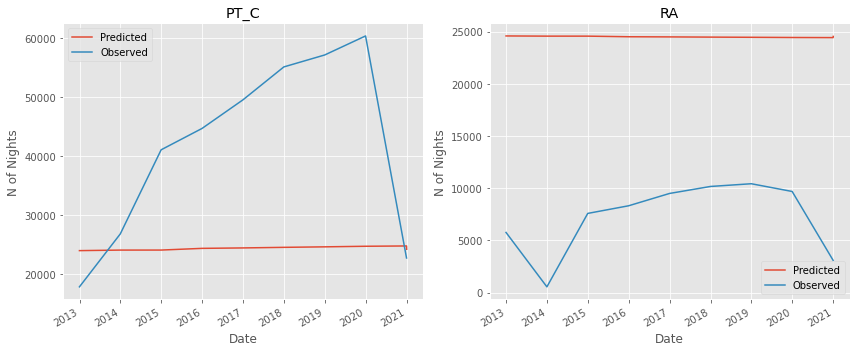

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plot_results(nutsi, axes, pred_arima_wlss)
plt.tight_layout()

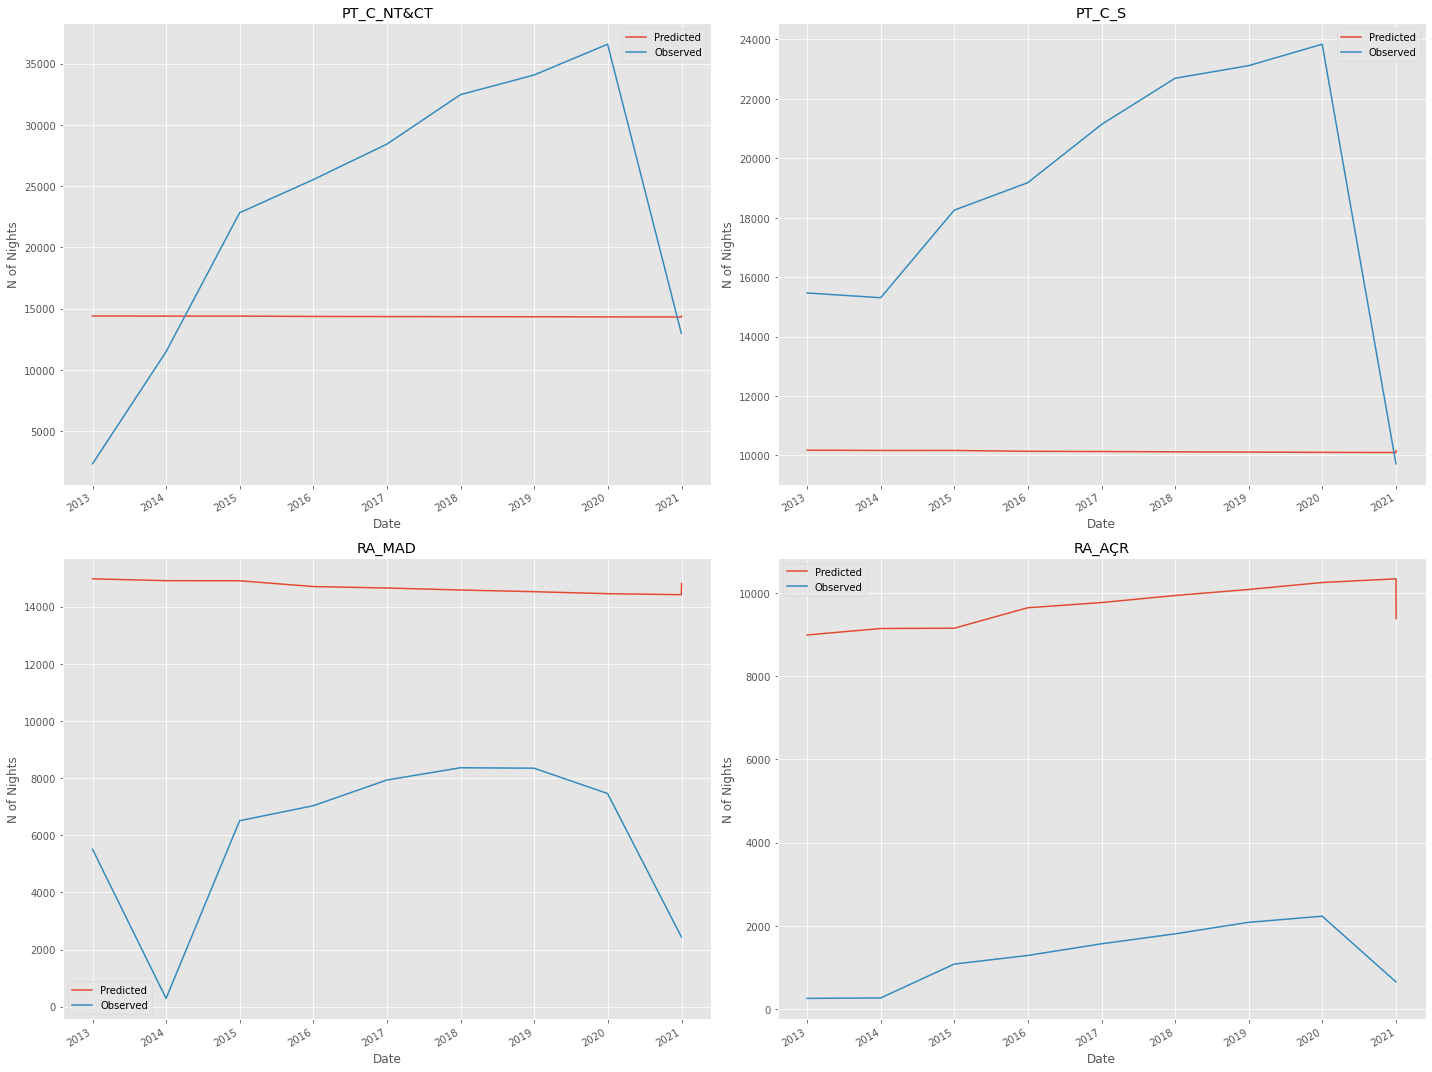

In [31]:
fig, axes = plt.subplots(2, 2, figsize=(20, 15))
plot_results(zones, axes, pred_arima_wlss)
plt.tight_layout()

## E) WLSV approach

Using the WLSV approach as a revision method (WLSV).

In [32]:
arima_wlsv = hts.HTSRegressor(model='auto_arima', revision_method='WLSV', n_jobs=0)
arima_wlsv = arima_wlss.fit(hierarchy_data, hierarchy)
pred_arima_wlsv = arima_wlss.predict(steps_ahead=1)

Fitting models: 100%|███████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 291.59it/s]


In [33]:
pred_arima_wlsv.round()

,total,PT_C,RA,PT_C_NT&CT,PT_C_S,RA_MAD,RA_AÇR
2012-12-31,48535.0,23955.0,24580.0,14400.0,10179.0,14970.0,8985.0
2013-12-31,48608.0,24047.0,24561.0,14391.0,10170.0,14906.0,9141.0
2014-12-31,48611.0,24051.0,24561.0,14391.0,10170.0,14903.0,9147.0
2015-12-31,48842.0,24339.0,24503.0,14362.0,10141.0,14701.0,9639.0
2016-12-31,48901.0,24413.0,24488.0,14355.0,10133.0,14649.0,9764.0
2017-12-31,48981.0,24513.0,24468.0,14345.0,10123.0,14580.0,9933.0
2018-12-31,49049.0,24598.0,24451.0,14336.0,10115.0,14520.0,10077.0
2019-12-31,49127.0,24696.0,24431.0,14326.0,10105.0,14451.0,10245.0
2020-12-31,49169.0,24748.0,24421.0,14321.0,10100.0,14415.0,10333.0
2021-01-01,48721.0,24187.0,24533.0,14377.0,10156.0,14807.0,9380.0


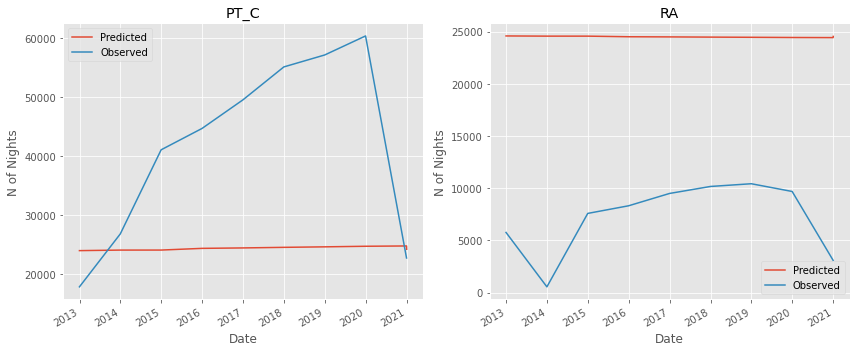

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plot_results(nutsi, axes, pred_arima_wlsv)
plt.tight_layout()

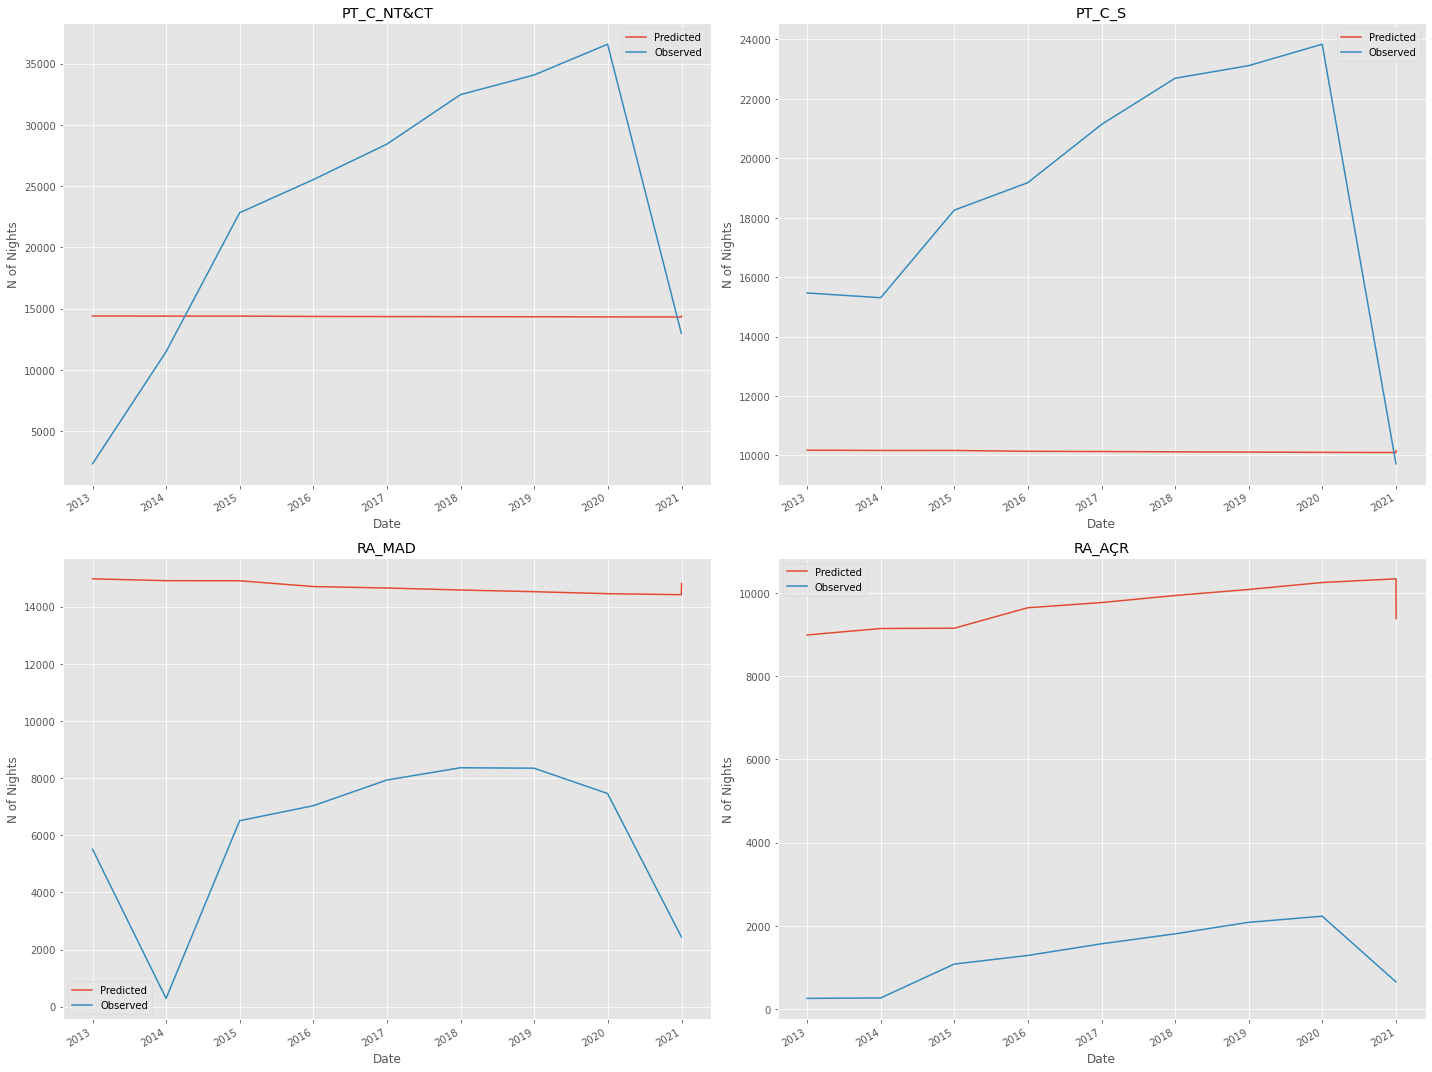

In [35]:
fig, axes = plt.subplots(2, 2, figsize=(20, 15))
plot_results(zones, axes, pred_arima_wlsv)
plt.tight_layout()

## 3.2. Using Prophet as base forecast

Calculating forecasts using Prophet model as base forecast

## A) Bottom-up approach

Using the Bottom-up approach as a revision method (BU).

In [36]:
prophet_bu = hts.HTSRegressor(model='prophet', revision_method='BU', n_jobs=0)
prophet_bu = prophet_bu.fit(hierarchy_data, hierarchy)
pred_prophet_bu = prophet_bu.predict(steps_ahead=1)

Fitting models:   0%|                                                                            | 0/7 [00:00<?, ?it/s]INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 6.
Fitting models:  14%|█████████▋                                                          | 1/7 [00:00<00:05,  1.00it/s]INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 6.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to overrid

In [37]:
pred_prophet_bu.round()

,total,PT_C,RA,PT_C_NT&CT,PT_C_S,RA_MAD,RA_AÇR
2012-12-31,27809.0,4507.0,23301.0,7796.0,15506.0,4223.0,284.0
2013-12-31,38608.0,5891.0,32717.0,15001.0,17716.0,5173.0,718.0
2014-12-31,49232.0,7271.0,41961.0,22098.0,19863.0,6123.0,1148.0
2015-12-31,59670.0,8646.0,51024.0,29081.0,21944.0,7071.0,1575.0
2016-12-31,38179.0,5845.0,32334.0,16292.0,16043.0,4967.0,878.0
2017-12-31,48979.0,7229.0,41750.0,23497.0,18253.0,5917.0,1311.0
2018-12-31,59602.0,8609.0,50994.0,30594.0,20399.0,6867.0,1742.0
2019-12-31,70040.0,9983.0,60057.0,37577.0,22481.0,7815.0,2169.0
2020-12-31,48550.0,7182.0,41367.0,24788.0,16579.0,5711.0,1471.0
2021-01-01,14169.0,2970.0,11199.0,3503.0,7696.0,2667.0,303.0


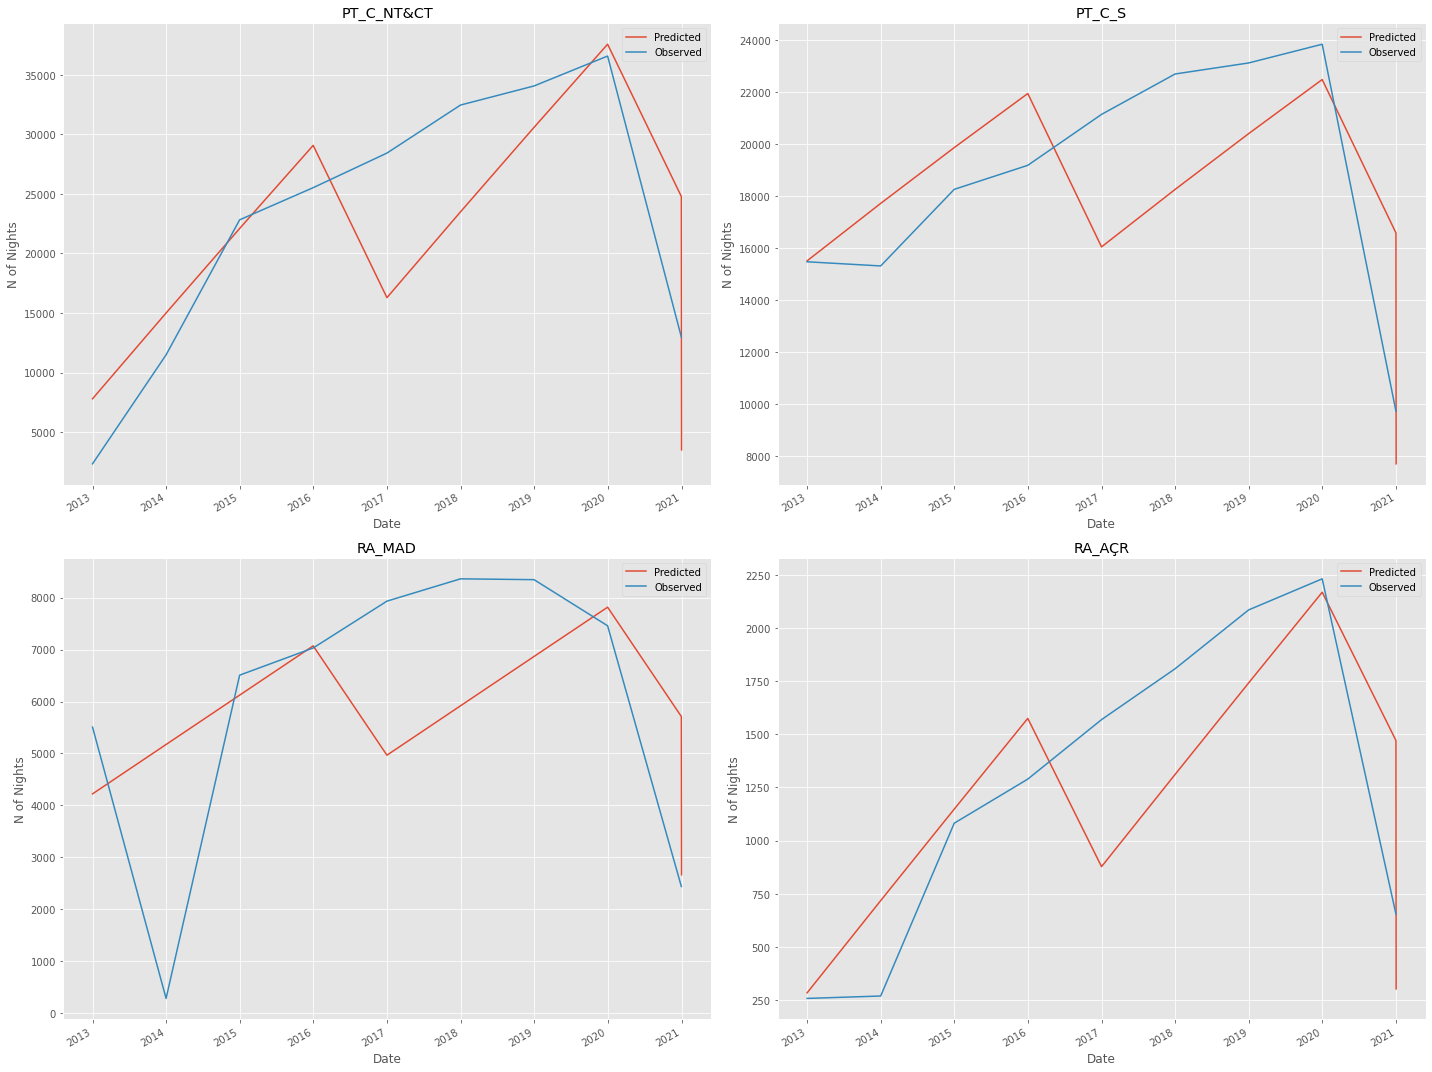

In [38]:
fig, axes = plt.subplots(2, 2, figsize=(20, 15))
plot_results(zones, axes, pred_prophet_bu)
plt.tight_layout()

## B) Top-down approach

Using the Top-down approach as a revision method (AHP).


In [39]:
prophet_td = hts.HTSRegressor(model='prophet', revision_method='AHP', n_jobs=0)
prophet_td = prophet_td.fit(hierarchy_data, hierarchy)
pred_prophet_td = prophet_td.predict(steps_ahead=1)

Fitting models:   0%|                                                                            | 0/7 [00:00<?, ?it/s]INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 6.
Fitting models:  14%|█████████▋                                                          | 1/7 [00:00<00:00,  9.75it/s]INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 6.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to overrid

In [40]:
pred_prophet_td.round()

,total,PT_C,RA,PT_C_NT&CT,PT_C_S,RA_MAD,RA_AÇR
2012-12-31,27804.0,4037.0,23767.0,12285.0,11482.0,3389.0,648.0
2013-12-31,38599.0,5604.0,32995.0,17055.0,15940.0,4705.0,899.0
2014-12-31,49228.0,7147.0,42081.0,21751.0,20330.0,6001.0,1146.0
2015-12-31,59682.0,8665.0,51017.0,26370.0,24647.0,7275.0,1390.0
2016-12-31,38160.0,5541.0,32620.0,16861.0,15759.0,4652.0,889.0
2017-12-31,48955.0,7108.0,41847.0,21630.0,20217.0,5968.0,1140.0
2018-12-31,59584.0,8651.0,50933.0,26327.0,24607.0,7263.0,1388.0
2019-12-31,70038.0,10169.0,59869.0,30946.0,28924.0,8538.0,1631.0
2020-12-31,48517.0,7044.0,41473.0,21437.0,20036.0,5914.0,1130.0
2021-01-01,14243.0,2068.0,12175.0,6293.0,5882.0,1736.0,332.0


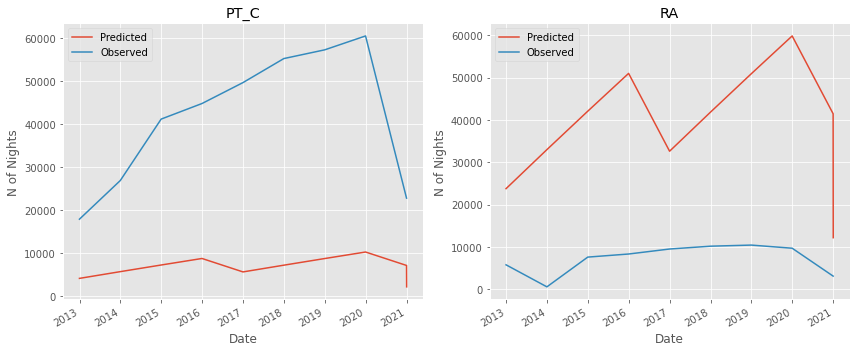

In [41]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plot_results(nutsi, axes, pred_prophet_td)
plt.tight_layout()

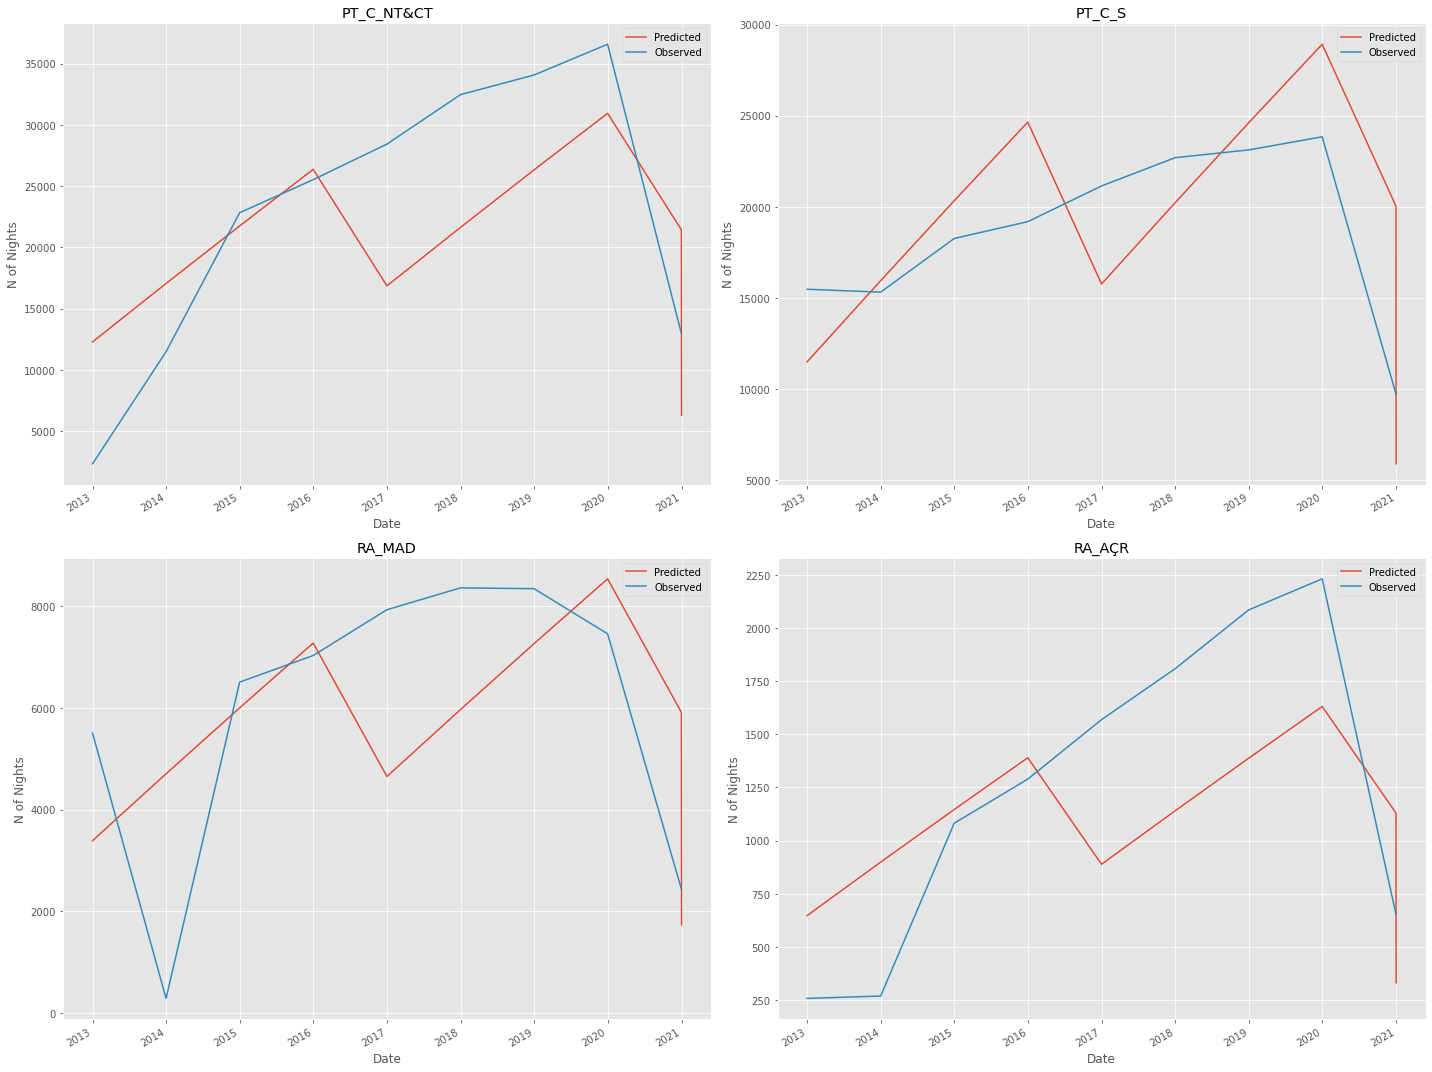

In [42]:
fig, axes = plt.subplots(2, 2, figsize=(20, 15))
plot_results(zones, axes, pred_prophet_td)
plt.tight_layout()

## C) optimal combination using OLS approach

Using the OLS approach as a revision method (OLS).

In [43]:
prophet_ols = hts.HTSRegressor(model='prophet', revision_method='OLS', n_jobs=0)
prophet_ols = prophet_ols.fit(hierarchy_data, hierarchy)
pred_prophet_ols = prophet_ols.predict(steps_ahead=1)

Fitting models:   0%|                                                                            | 0/7 [00:00<?, ?it/s]INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 6.
Fitting models:  14%|█████████▋                                                          | 1/7 [00:00<00:00,  9.23it/s]INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 6.
Fitting models:  29%|███████████████████▍                                                | 2/7 [00:00<00:00,  9.45it/s]INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonalit

In [44]:
pred_prophet_ols.round()

,total,PT_C,RA,PT_C_NT&CT,PT_C_S,RA_MAD,RA_AÇR
2012-12-31,27803.0,17030.0,10773.0,1531.0,9241.0,10485.0,6546.0
2013-12-31,38603.0,23776.0,14828.0,6057.0,8771.0,14116.0,9660.0
2014-12-31,49231.0,30403.0,18829.0,10532.0,8296.0,17689.0,12714.0
2015-12-31,59677.0,36905.0,22771.0,14954.0,7817.0,21200.0,15705.0
2016-12-31,38162.0,23491.0,14671.0,7460.0,7211.0,13790.0,9701.0
2017-12-31,48963.0,30236.0,18726.0,11985.0,6741.0,17421.0,12815.0
2018-12-31,59590.0,36863.0,22727.0,16461.0,6266.0,20994.0,15869.0
2019-12-31,70036.0,43366.0,26670.0,20883.0,5787.0,24506.0,18860.0
2020-12-31,48521.0,29951.0,18570.0,13389.0,5181.0,17096.0,12856.0
2021-01-01,14158.0,8374.0,5784.0,795.0,4988.0,5369.0,3005.0


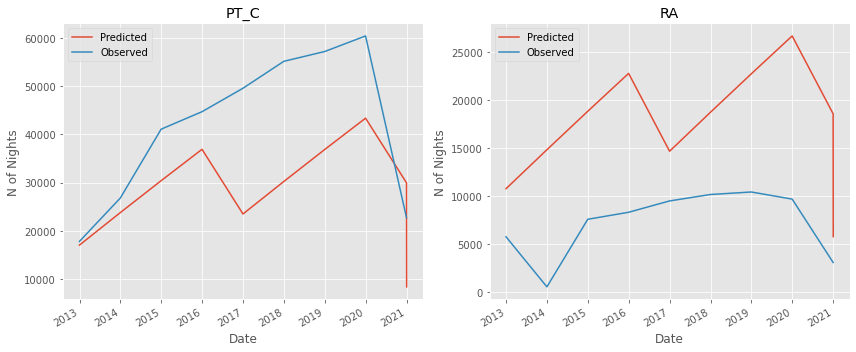

In [45]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plot_results(nutsi, axes, pred_prophet_ols)
plt.tight_layout()

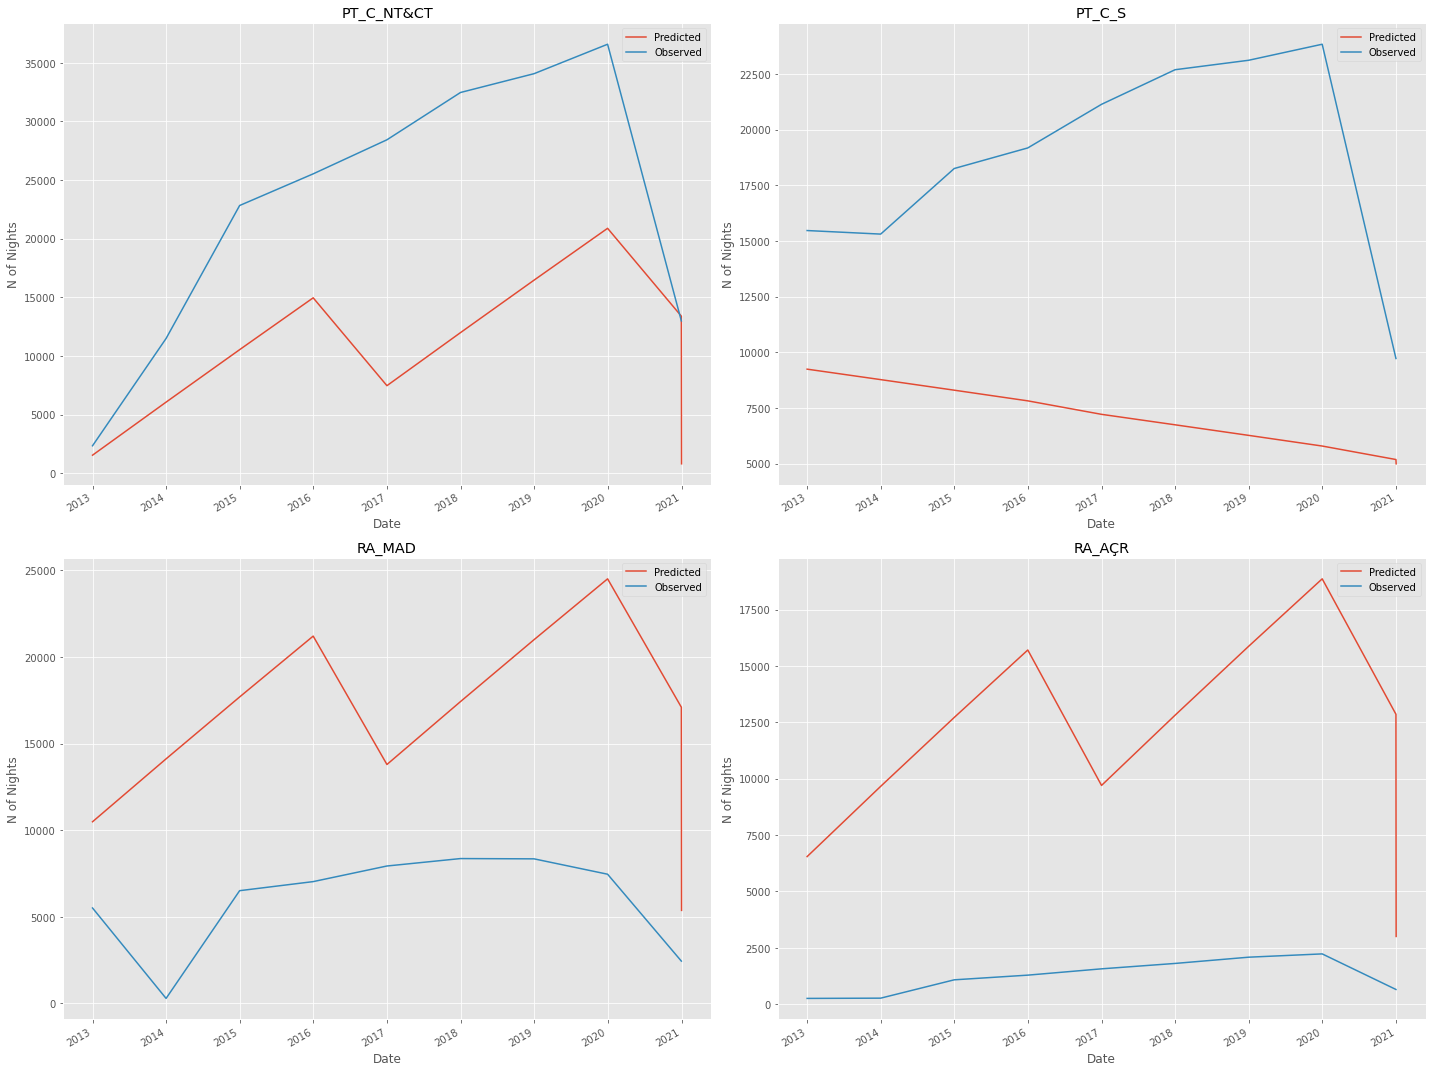

In [46]:
fig, axes = plt.subplots(2, 2, figsize=(20, 15))
plot_results(zones, axes, pred_prophet_ols)
plt.tight_layout()

## D) WLSS approach

Using the WLSS approach as a revision method (WLSS).

In [47]:
prophet_wlss = hts.HTSRegressor(model='prophet', revision_method='WLSS', n_jobs=0)
prophet_wlss = prophet_wlss.fit(hierarchy_data, hierarchy)
pred_prophet_wlss = prophet_wlss.predict(steps_ahead=1)

Fitting models:   0%|                                                                            | 0/7 [00:00<?, ?it/s]INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 6.
Fitting models:  14%|█████████▋                                                          | 1/7 [00:00<00:00,  9.61it/s]INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 6.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to overrid

In [48]:
pred_arima_wlss.round()

,total,PT_C,RA,PT_C_NT&CT,PT_C_S,RA_MAD,RA_AÇR
2012-12-31,48535.0,23955.0,24580.0,14400.0,10179.0,14970.0,8985.0
2013-12-31,48608.0,24047.0,24561.0,14391.0,10170.0,14906.0,9141.0
2014-12-31,48611.0,24051.0,24561.0,14391.0,10170.0,14903.0,9147.0
2015-12-31,48842.0,24339.0,24503.0,14362.0,10141.0,14701.0,9639.0
2016-12-31,48901.0,24413.0,24488.0,14355.0,10133.0,14649.0,9764.0
2017-12-31,48981.0,24513.0,24468.0,14345.0,10123.0,14580.0,9933.0
2018-12-31,49049.0,24598.0,24451.0,14336.0,10115.0,14520.0,10077.0
2019-12-31,49127.0,24696.0,24431.0,14326.0,10105.0,14451.0,10245.0
2020-12-31,49169.0,24748.0,24421.0,14321.0,10100.0,14415.0,10333.0
2021-01-01,48721.0,24187.0,24533.0,14377.0,10156.0,14807.0,9380.0


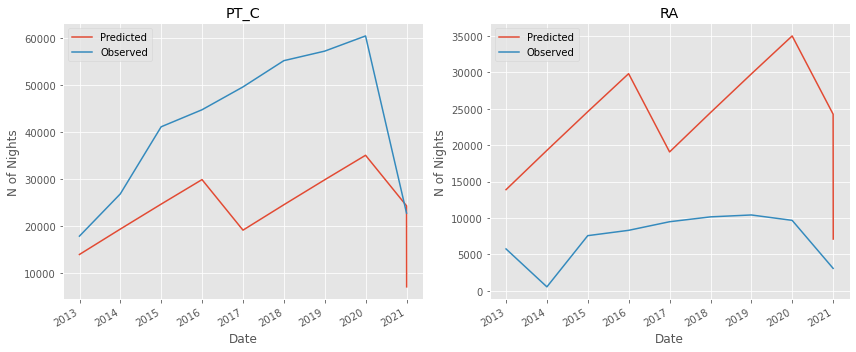

In [49]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plot_results(nutsi, axes, pred_prophet_wlss)
plt.tight_layout()

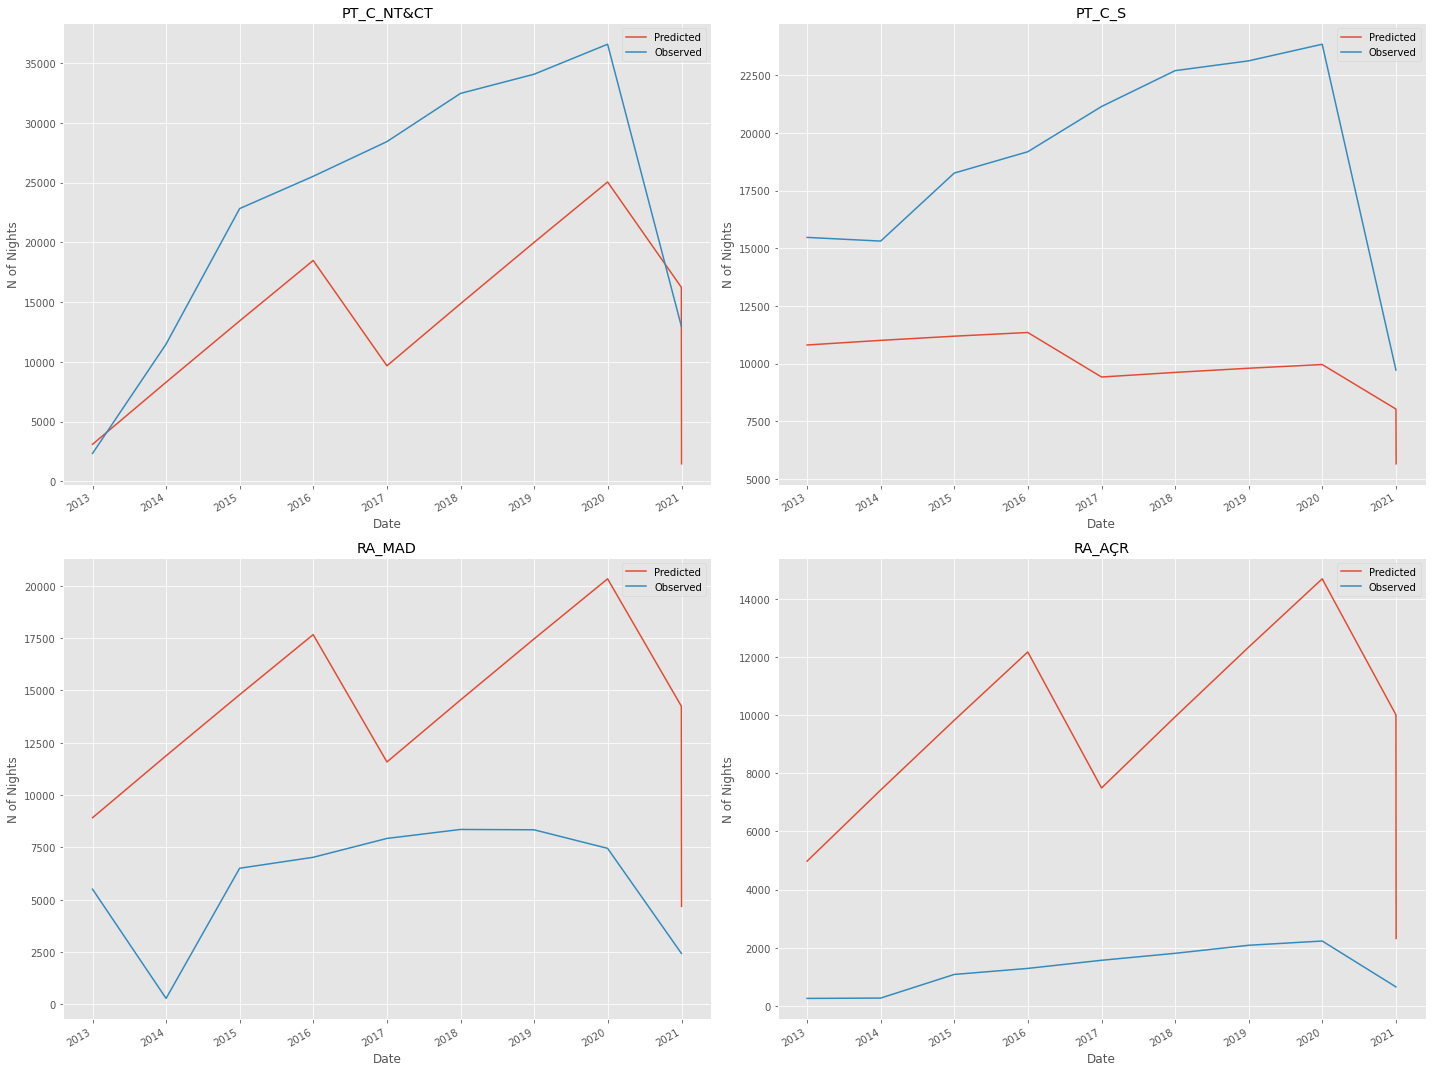

In [50]:
fig, axes = plt.subplots(2, 2, figsize=(20, 15))
plot_results(zones, axes, pred_prophet_wlss)
plt.tight_layout()

## E) WLSV approach

Using the WLSV approach as a revision method (WLSV).

In [51]:
prophet_wlsv = hts.HTSRegressor(model='prophet', revision_method='WLSV', n_jobs=0)
prophet_wlsv = prophet_wlss.fit(hierarchy_data, hierarchy)
pred_prophet_wlsv = prophet_wlss.predict(steps_ahead=1)

Fitting models:   0%|                                                                            | 0/7 [00:00<?, ?it/s]INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 6.
Fitting models:  14%|█████████▋                                                          | 1/7 [00:00<00:00,  9.52it/s]INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 6.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to overrid

In [52]:
pred_prophet_wlsv.round()

,total,PT_C,RA,PT_C_NT&CT,PT_C_S,RA_MAD,RA_AÇR
2012-12-31,27803.0,13899.0,13904.0,3097.0,10807.0,8919.0,4980.0
2013-12-31,38606.0,19305.0,19301.0,8293.0,11007.0,11880.0,7425.0
2014-12-31,49232.0,24620.0,24612.0,13424.0,11188.0,14797.0,9823.0
2015-12-31,59674.0,29840.0,29834.0,18486.0,11348.0,17668.0,12172.0
2016-12-31,38166.0,19079.0,19087.0,9668.0,9419.0,11584.0,7495.0
2017-12-31,48968.0,24485.0,24483.0,14864.0,9619.0,14545.0,9940.0
2018-12-31,59594.0,29800.0,29794.0,19995.0,9800.0,17463.0,12338.0
2019-12-31,70036.0,35019.0,35016.0,25056.0,9960.0,20333.0,14687.0
2020-12-31,48528.0,24259.0,24269.0,16239.0,8030.0,14249.0,10009.0
2021-01-01,14131.0,7008.0,7123.0,1465.0,5658.0,4686.0,2322.0


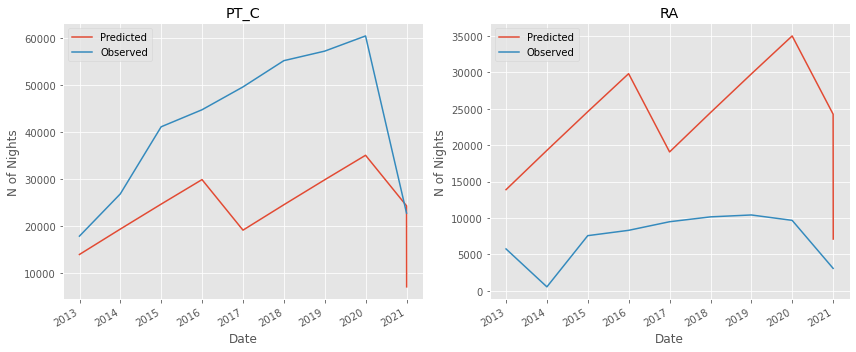

In [53]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plot_results(nutsi, axes, pred_prophet_wlsv)
plt.tight_layout()

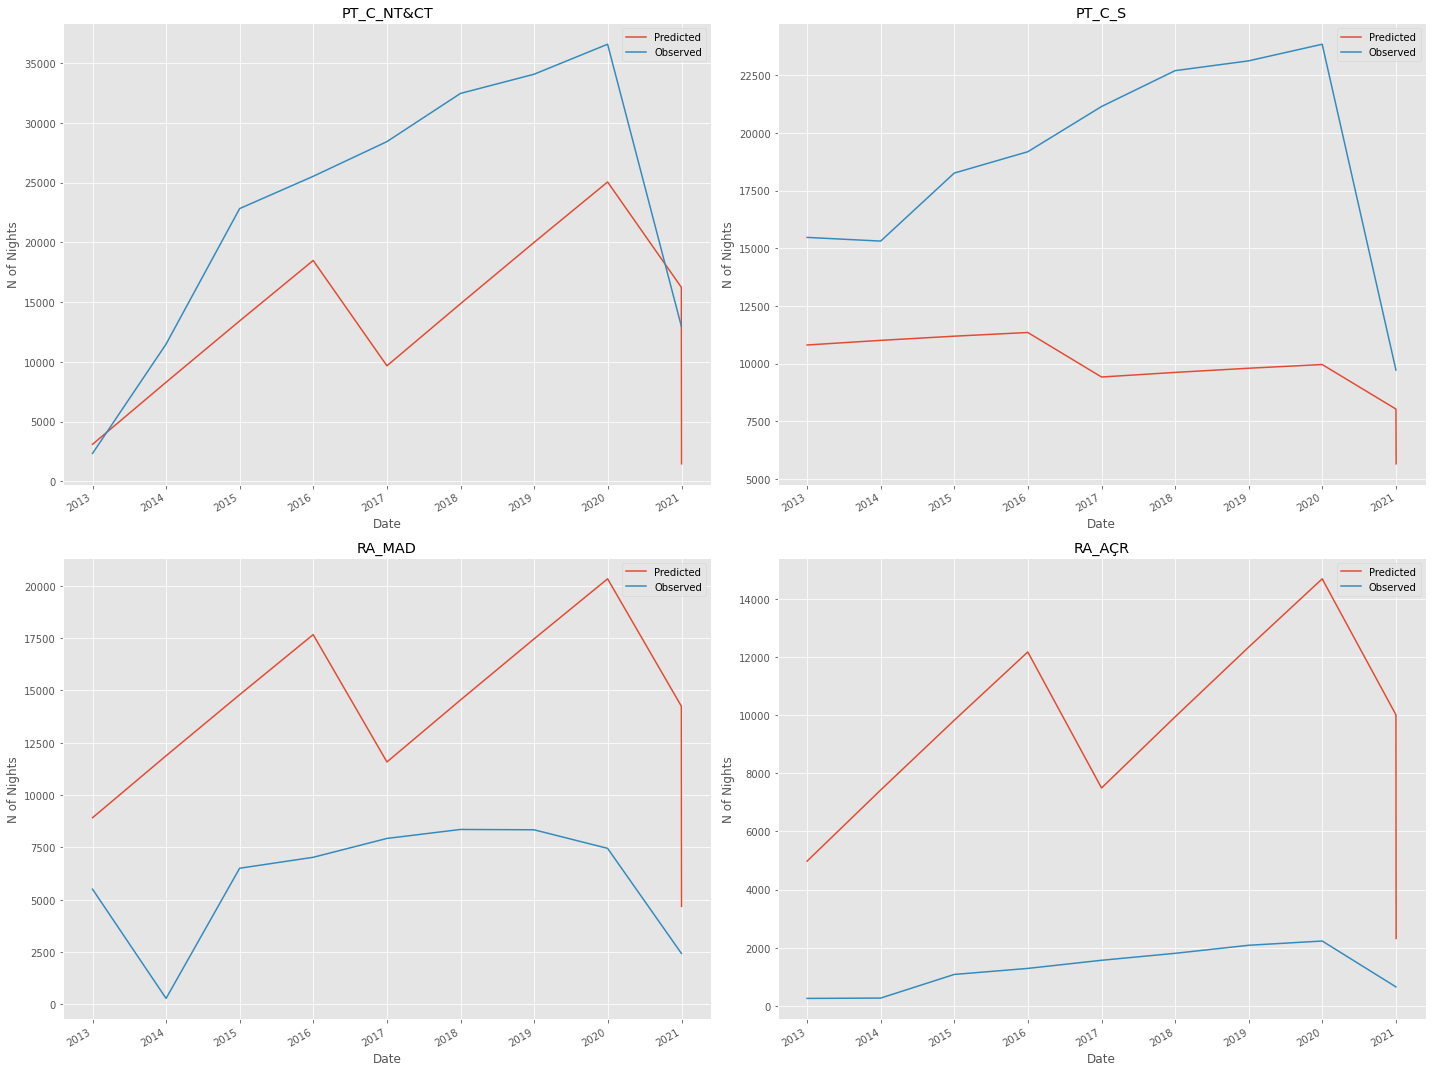

In [54]:
fig, axes = plt.subplots(2, 2, figsize=(20, 15))
plot_results(zones, axes, pred_prophet_wlsv)
plt.tight_layout()

## 4. Comparing the forecasts

Calculate the RMSE of each model and build a dataframe with these.

In [55]:
#Drop the year 2021
pred_arima_bu.drop(pred_arima_bu.tail(1).index,inplace=True) 
pred_arima_td.drop(pred_arima_td.tail(1).index,inplace=True) 
pred_arima_ols.drop(pred_arima_ols.tail(1).index,inplace=True) 
pred_arima_wlss.drop(pred_arima_wlss.tail(1).index,inplace=True) 
pred_arima_wlsv.drop(pred_arima_wlsv.tail(1).index,inplace=True) 
pred_prophet_bu.drop(pred_prophet_bu.tail(1).index,inplace=True) 
pred_prophet_td.drop(pred_prophet_td.tail(1).index,inplace=True) 
pred_prophet_ols.drop(pred_prophet_ols.tail(1).index,inplace=True) 
pred_prophet_wlss.drop(pred_prophet_wlss.tail(1).index,inplace=True) 
pred_prophet_wlsv.drop(pred_prophet_wlsv.tail(1).index,inplace=True)

In [56]:
#Build a dataframe with the RMSE in each model and in each location
df_rmse = pd.DataFrame()

for z in hierarchy_data.columns:
    error_pred_arima_bu=hierarchy_data[f'{z}'].values-pred_arima_bu[f'{z}'].values
    error_pred_arima_td=hierarchy_data[f'{z}'].values-pred_arima_td[f'{z}'].values
    error_pred_arima_ols=hierarchy_data[f'{z}'].values-pred_arima_ols[f'{z}'].values
    error_pred_arima_wlss=hierarchy_data[f'{z}'].values-pred_arima_wlss[f'{z}'].values
    error_pred_arima_wlsv=hierarchy_data[f'{z}'].values-pred_arima_wlsv[f'{z}'].values
    error_pred_prophet_bu=hierarchy_data[f'{z}'].values-pred_prophet_bu[f'{z}'].values
    error_pred_prophet_td=hierarchy_data[f'{z}'].values-pred_prophet_td[f'{z}'].values
    error_pred_prophet_ols=hierarchy_data[f'{z}'].values-pred_prophet_ols[f'{z}'].values
    error_pred_prophet_wlss=hierarchy_data[f'{z}'].values-pred_prophet_wlss[f'{z}'].values
    error_pred_prophet_wlsv=hierarchy_data[f'{z}'].values-pred_prophet_wlsv[f'{z}'].values

    rmse_pred_arima_bu=(error_pred_arima_bu**2).mean()**0.5
    rmse_pred_arima_td=(error_pred_arima_td**2).mean()**0.5
    rmse_pred_arima_ols=(error_pred_arima_ols**2).mean()**0.5
    rmse_pred_arima_wlss=(error_pred_arima_wlss**2).mean()**0.5
    rmse_pred_arima_wlsv=(error_pred_arima_wlsv**2).mean()**0.5
    rmse_pred_prophet_bu=(error_pred_prophet_bu**2).mean()**0.5
    rmse_pred_prophet_td=(error_pred_prophet_td**2).mean()**0.5
    rmse_pred_prophet_ols=(error_pred_prophet_ols**2).mean()**0.5
    rmse_pred_prophet_wlss=(error_pred_prophet_wlss**2).mean()**0.5
    rmse_pred_prophet_wlsv=(error_pred_prophet_wlsv**2).mean()**0.5
    
    df_rmse[f'{z}']=[rmse_pred_arima_bu,rmse_pred_arima_td,rmse_pred_arima_ols,rmse_pred_arima_wlss,rmse_pred_arima_wlsv,rmse_pred_prophet_bu,rmse_pred_prophet_td,rmse_pred_prophet_ols,rmse_pred_prophet_wlss,rmse_pred_prophet_wlsv]
    df_rmse['model']=['rmse_pred_arima_bu','rmse_pred_arima_td','rmse_pred_arima_ols','rmse_pred_arima_wlss','rmse_pred_arima_wlsv','rmse_pred_prophet_bu','rmse_pred_prophet_td','rmse_pred_prophet_ols','rmse_pred_prophet_wlss','rmse_pred_prophet_wlsv']
    df_rmse.set_index(['model'], inplace=True)



In [57]:
df_rmse.round()

,PT_C_NT&CT,PT_C_S,RA_AÇR,RA_MAD,PT_C,RA,total
model,,,,,,,
rmse_pred_arima_bu,11019.0,4357.0,617.0,2662.0,37655.0,34634.0,17406.0
rmse_pred_arima_td,11100.0,4597.0,708.0,2662.0,37679.0,34761.0,17735.0
rmse_pred_arima_ols,15928.0,12284.0,11354.0,11908.0,18787.0,11974.0,17686.0
rmse_pred_arima_wlss,13998.0,9653.0,8463.0,9109.0,22770.0,17569.0,17623.0
rmse_pred_arima_wlsv,13998.0,9653.0,8463.0,9109.0,22770.0,17569.0,17623.0
rmse_pred_prophet_bu,6958.0,3621.0,447.0,2436.0,37138.0,35766.0,12802.0
rmse_pred_prophet_td,7793.0,4945.0,532.0,2476.0,37215.0,35837.0,12803.0
rmse_pred_prophet_ols,13782.0,12423.0,11895.0,12127.0,15787.0,12215.0,12802.0
rmse_pred_prophet_wlss,11317.0,9619.0,8928.0,9237.0,20636.0,18049.0,12802.0


In [58]:
#The minimum:
df_rmse.min()
#That corresponds to the following location:
df_rmse.idxmin()

PT_C_NT&CT     rmse_pred_prophet_bu
PT_C_S         rmse_pred_prophet_bu
RA_AÇR         rmse_pred_prophet_bu
RA_MAD         rmse_pred_prophet_bu
PT_C          rmse_pred_prophet_ols
RA              rmse_pred_arima_ols
total          rmse_pred_prophet_bu
dtype: object

In [59]:
#Best model in level 1
rmse_level1_hier=df_rmse.iloc[:,[6]]
rmse_level1_hier["Level 1"] = rmse_level1_hier.sum(axis=1)
print(rmse_level1_hier.round())

                          total  Level 1
model                                   
rmse_pred_arima_bu      17406.0  17406.0
rmse_pred_arima_td      17735.0  17735.0
rmse_pred_arima_ols     17686.0  17686.0
rmse_pred_arima_wlss    17623.0  17623.0
rmse_pred_arima_wlsv    17623.0  17623.0
rmse_pred_prophet_bu    12802.0  12802.0
rmse_pred_prophet_td    12803.0  12803.0
rmse_pred_prophet_ols   12802.0  12802.0
rmse_pred_prophet_wlss  12802.0  12802.0
rmse_pred_prophet_wlsv  12802.0  12802.0


In [60]:
bestmodel_level1=rmse_level1_hier.round().iloc[:,[1]].idxmin()
bestmodel_level1

Level 1    rmse_pred_prophet_bu
dtype: object

In [61]:
#Best model in level 2
rmse_level2_hier=df_rmse.iloc[:,[4,5]]
rmse_level2_hier["Level 2"] = rmse_level2_hier.sum(axis=1)
print(rmse_level2_hier.round())

                           PT_C       RA  Level 2
model                                            
rmse_pred_arima_bu      37655.0  34634.0  72290.0
rmse_pred_arima_td      37679.0  34761.0  72441.0
rmse_pred_arima_ols     18787.0  11974.0  30761.0
rmse_pred_arima_wlss    22770.0  17569.0  40338.0
rmse_pred_arima_wlsv    22770.0  17569.0  40338.0
rmse_pred_prophet_bu    37138.0  35766.0  72904.0
rmse_pred_prophet_td    37215.0  35837.0  73052.0
rmse_pred_prophet_ols   15787.0  12215.0  28003.0
rmse_pred_prophet_wlss  20636.0  18049.0  38685.0
rmse_pred_prophet_wlsv  20636.0  18049.0  38685.0


In [62]:
bestmodel_level2=rmse_level2_hier.round().iloc[:,[2]].idxmin()
bestmodel_level2

Level 2    rmse_pred_prophet_ols
dtype: object

In [63]:
#Best model in level 3
rmse_level3_hier=df_rmse.iloc[:,[0,1,2,3]]
rmse_level3_hier["Level 3"] = rmse_level3_hier.sum(axis=1)
print(rmse_level3_hier.round())

                        PT_C_NT&CT   PT_C_S   RA_AÇR   RA_MAD  Level 3
model                                                                 
rmse_pred_arima_bu         11019.0   4357.0    617.0   2662.0  18655.0
rmse_pred_arima_td         11100.0   4597.0    708.0   2662.0  19068.0
rmse_pred_arima_ols        15928.0  12284.0  11354.0  11908.0  51474.0
rmse_pred_arima_wlss       13998.0   9653.0   8463.0   9109.0  41222.0
rmse_pred_arima_wlsv       13998.0   9653.0   8463.0   9109.0  41222.0
rmse_pred_prophet_bu        6958.0   3621.0    447.0   2436.0  13463.0
rmse_pred_prophet_td        7793.0   4945.0    532.0   2476.0  15746.0
rmse_pred_prophet_ols      13782.0  12423.0  11895.0  12127.0  50227.0
rmse_pred_prophet_wlss     11317.0   9619.0   8928.0   9237.0  39100.0
rmse_pred_prophet_wlsv     11317.0   9619.0   8928.0   9237.0  39100.0


In [64]:
bestmodel_level3=rmse_level3_hier.round().iloc[:,[4]].idxmin()
bestmodel_level3

Level 3    rmse_pred_prophet_bu
dtype: object

## 5. Conclusions 

Through the analysis made above, it is possible to conclude that the model that performs more accurate forecasts is the Prophet model, for all levels of the hierarchy. Regarding the most appropriate reconciliation method, we have  found some differences. For level 1 and 3 of the hierarchy, the one that produces the most accurate forecasts is the bottom-up approach. However, for level 2 of the hierarchy, the most suitable is the OLS.